# **Notebook 3: Fusion Experiments**
In this notebook, we conduct experiments to answer two questions:
1. How should we combine the outputs of each input modality?
2. How should we predict basic emotions and binary sentiment from complex emotion?

Read on for a more detailed explanation of both questions :)


## **Initialization and Data Processing**
We load a JSON of the sentence-by-sentence Hume predictions on the full MELD dataset. See the previous workbooks for how that JSON is generated and cleaned up.

In [3]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

In [4]:
def load_json_to_df(directory):
    '''
    converts JSON output to a PD dataframe
    each JSON contains the predicted emotions for one sentence
    '''
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                content = json.load(file)
                metadata = content['metadata']

                # sentiment data
                face_emotions = lowercase_keys(content['predicted']['face'])
                prosody_emotions = lowercase_keys(content['predicted']['prosody'])
                lang_emotions = lowercase_keys(content['predicted']['lang'])

                data.append({
                    'dialogue_id': metadata['dialogue_id'],
                    'time_start': metadata['time_start'],
                    'time_end': metadata['time_end'],
                    'speaker': metadata['speaker'],
                    'emotion': metadata['emotion'],
                    'sentiment': metadata['sentiment'],
                    'text_content': metadata['text_content'],
                    'file_name': metadata['file_name'],
                    'face': face_emotions,
                    'prosody': prosody_emotions,
                    'lang': lang_emotions
                })
                
    return pd.DataFrame(data)

In [5]:
def lowercase_keys(dictionary):
    '''
    changes all (String) keys in a dictionary to be fully lower case
    '''
    return {key.lower(): value for key, value in dictionary.items()}

In [6]:
dataset_directory = './dataset/outputs/merged_all'
df = load_json_to_df(dataset_directory)

In [7]:
def get_emotion_scores(df):
    '''
    adds a column for each Hume/complex emotion, which contains a list of form [face_intensity, prosody_intensity, language_intensity]
    '''
    df_with_emotions = df.copy()
    for emotion in all_emotions:
        df_with_emotions[emotion] = df.apply(lambda row: [
            row['face'].get(emotion, None),
            row['prosody'].get(emotion, None),
            row['lang'].get(emotion, None)
        ], axis=1)
            
    return df_with_emotions

## **Exploring Our Emotion Data**
Hume has three models that predict emotion based on different modality. One model predicts based on language (the words spoken), another based on prosody (tone of voice, pauses, and vocables), and the last on facial expression. The prosody and face models output 48 emotions. The language model outputs 53 emotions. The five additional emotions output by the language model are {'Annoyance', 'Disapproval', 'Enthusiasm', 'Gratitude', 'Sarcasm'}.

Critically, the MELD dataset contains many sentences labeled with the 7 basic emotions (anger, sadness, fear, joy, surprise, disgust, and neutral). The Hume outputs are _not_ the same as the MELD dataset labels. Going forward, we will refer to the Hume outputs as "complex emotions" and the MELD dataset labels as "basic emotions." As you'll see below, a key part of our work is reducing predictions about "complex emotions" to predictions about "basic emotions."

In [8]:
lang_emotions = set(df['lang'][0].keys())
prosody_emotions = set(df['prosody'][0].keys())
face_emotions = set(df['face'][0].keys())

print("Number of outputted emotions in lang, prosody, and face models:", len(lang_emotions), len(prosody_emotions), len(face_emotions))
print("Emotions outputted by language model but not prosody model:", lang_emotions-prosody_emotions)
print("Emotions outputted by prosody model but not face model:", prosody_emotions-face_emotions)

all_emotions = sorted(list(lang_emotions))
print('All emotions:', all_emotions)

Number of outputted emotions in lang, prosody, and face models: 53 48 48
Emotions outputted by language model but not prosody model: {'gratitude', 'disapproval', 'annoyance', 'sarcasm', 'enthusiasm'}
Emotions outputted by prosody model but not face model: set()
All emotions: ['admiration', 'adoration', 'aesthetic appreciation', 'amusement', 'anger', 'annoyance', 'anxiety', 'awe', 'awkwardness', 'boredom', 'calmness', 'concentration', 'confusion', 'contemplation', 'contempt', 'contentment', 'craving', 'desire', 'determination', 'disappointment', 'disapproval', 'disgust', 'distress', 'doubt', 'ecstasy', 'embarrassment', 'empathic pain', 'enthusiasm', 'entrancement', 'envy', 'excitement', 'fear', 'gratitude', 'guilt', 'horror', 'interest', 'joy', 'love', 'nostalgia', 'pain', 'pride', 'realization', 'relief', 'romance', 'sadness', 'sarcasm', 'satisfaction', 'shame', 'surprise (negative)', 'surprise (positive)', 'sympathy', 'tiredness', 'triumph']


### **Emotion Maps**

Below, we create maps from the output of Hume AI (up to 53 emotions) to the seven basic emotions in our dataset. We also map the Hume AI emotions to positive/negative sentiment. Annotations below are manually created. Interesting future exploration could involve mapping each Hume/complex emotion to a weighted sum of the 7 basic emotions, potentially through training an ML model.

In [9]:
BASIC_TO_COMPLEX = {
  'anger': ['anger', 'annoyance', 'disapproval'],
  'fear': ['anxiety', 'doubt', 'fear', 'horror'],
  'joy': ['admiration', 'adoration', 'amusement', 'contentment', 'desire', 'ecstasy', 'enthusiasm', 'entrancement', 'excitement', 'gratitude', 'joy', 'love', 'pride', 'relief', 'romance', 'triumph'],
  'sadness': ['disappointment', 'distress', 'empathic pain', 'guilt', 'nostalgia', 'pain', 'sadness'],
  'surprise': ['awe', 'confusion', 'realization', 'surprise (negative)', 'surprise (positive)'],
  'disgust': ['contempt', 'disgust', 'envy', 'sarcasm'],
  'neutral': ['aesthetic appreciation', 'awkwardness', 'boredom', 'calmness', 'concentration', 'contemplation', 'craving', 'determination', 'embarrassment', 'interest', 'satisfaction', 'shame', 'sympathy', 'tiredness']
}

In [10]:
SENTIMENT_TO_EMOTION = {
  'positive': [
    'admiration', 'adoration', 'aesthetic appreciation', 'amusement', 'awe', 'contentment', 'desire', 'ecstasy', 'enthusiasm', 'entrancement', 'excitement', 'gratitude', 'joy', 'love', 'pride', 'relief', 'romance', 'triumph'
  ],
  'negative': [
    'anger', 'annoyance', 'anxiety', 'awkwardness', 'boredom', 'contempt', 'confusion', 'craving', 'disappointment', 'disapproval', 'disgust', 'distress', 'doubt', 'empathic pain', 'embarrassment', 'envy', 'fear', 'guilt', 'horror', 'nostalgia', 'pain', 'sadness', 'sarcasm', 'shame', 'surprise (negative)', 'sympathy', 'tiredness'
  ]
}

## **Methods To Fuse Modalities**
Hume has a facial expression model (predicts based on frame capture of facial expressions in a video), a prosody model (predicts based on signal waveform), and language model (predicts based off words spoken). Each model outputs predictions for up to 53 emotions based on the given input modality. We experiment with two methods to combine the outputs from different modalities to obtain a single number representing the intensity of each emotion.
1. The first method is a simple sum. To get the intensity of an emotion, this function sums the intensity predicated for each modality. In other words: `awe_intensity = face_awe_intensity + prosody_awe_intensity + lang_awe_intensity`
2. The second method is a relative sum. To get the intensity of an emotion, this function takes sums the intensity predicated for each modality, weighted by the predictive accuracy of that modality alone. In other words: `awe_intensity = face_awe_intensity * relative accuracy of face-only prediction + ... (the same for prosody and language)`

### **Method 1: Simple Sum**

In [11]:
def get_simple_sum(df):
    '''
    to get the intensity of an emotion, this function sums the intensity predicated for each modality. In other words:
    awe_intensity = face_awe_intensity + prosody_awe_intensity + lang_awe_intensity
    '''
    simple_sum_df = df.copy()
    for emotion in all_emotions:
        simple_sum_df[emotion] = df[emotion].apply(lambda x: sum([i for i in x if i is not None]))
    return simple_sum_df

### **Method 2: Relative Sum**
We calculate the extent to which each individual modality predicts the final emotion, and use the relative accuracy of each modality to weight the final sum.

#### **2a: Accuracy of Individual Modalities**
First, we test each individual modality to see how predictive it is of the final emotion.

In [12]:
def get_predictions(df, mapping, modality):
    '''
    predicts which basic emotion dominates by taking the mean of all complex emotions corresponding to that basic emotion, and choosing the basic emotion with the highest intensity
    '''
    intensities = pd.DataFrame()
    basic_emotions = sorted(list(mapping.keys()))
    
    for basic_emotion in basic_emotions:
        # this is a disgusting list comprehension that came from flattening a long loop
        complex_emotions = pd.concat([df[modality].apply(lambda row: row.get(complex_emotion, np.nan)).rename(complex_emotion) for complex_emotion in mapping[basic_emotion]], axis=1)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            intensities[basic_emotion] = np.nanmean(complex_emotions, axis=1) # column names: basic emotions; each row is a sentence; values are the intensities of the basic emotion for that sentence

    # drop all rows that have all nan values
    intensities = intensities.dropna(how='all')
    
    y_pred = intensities.idxmax(axis=1)
    return y_pred

In [13]:
def get_accuracy(df, target, modality):
    '''
    reports the accuracy of the approach above compared to ground truth
    @param df with a column `y_pred` and a column with the name `target`
    @returns the percent of rows that have identical `y_pred` and `target` values
    ''' 
    if target == 'emotion':
        mapping = BASIC_TO_COMPLEX
    elif target == 'sentiment':
        mapping = SENTIMENT_TO_EMOTION
    else:
        raise Exception('Invalid target')
        
    y_pred = get_predictions(df, mapping, modality)
    comparable_columns = df[target].loc[y_pred.index]
    total_sentences = len(comparable_columns)
    accuracy = np.sum(y_pred == comparable_columns) / total_sentences
    return accuracy

In [14]:
def calc_relative_weights(df, show_results=False):
    # run on all combinations of emotions and modalities
    targets = ['emotion', 'sentiment']
    modalities = ['face','prosody','lang']
    
    results = pd.DataFrame(index=targets, columns=modalities)
    
    for target in targets:
        for modality in modalities:
            accuracy = get_accuracy(df, target, modality)
            results.at[target, modality] = accuracy
    results = results.astype(float)

    # calculate and return relative weights
    relative_weights = results.apply(lambda row: row / np.sum(row), axis=1)
    
    if show_results:
        print("Accuracy by Modality")
        display(results)
        print("Relative Modality Weights")
        display(relative_weights)
    
        # plot heatmap
        fig, ax = plt.subplots()
        heatmap = ax.imshow(results, cmap='viridis', interpolation='nearest')
        
        ax.set_xticks(np.arange(len(modalities)))
        ax.set_yticks(np.arange(len(targets)))
        ax.set_xticklabels(modalities)
        ax.set_yticklabels(targets)
        plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")
        plt.colorbar(heatmap)
        
        ax.set_title('Accuracy Scores by Target and Modality')
        plt.xlabel('Modalities')
        plt.ylabel('Targets')
        
        plt.show()

    return relative_weights

Accuracy by Modality


,face,prosody,lang
emotion,0.223697,0.280374,0.357610
sentiment,0.399052,0.400000,0.427638


Relative Modality Weights


,face,prosody,lang
emotion,0.259605,0.325380,0.415014
sentiment,0.325308,0.326081,0.348611


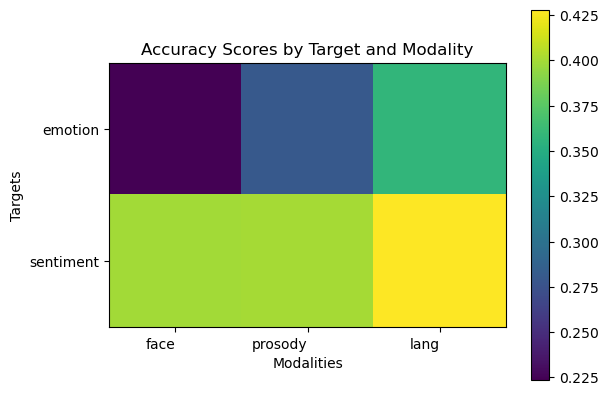

In [15]:
unfused_data = get_emotion_scores(df)
weights = calc_relative_weights(unfused_data, show_results=True)

#### **2b: Fusion**
And now let's put those relative weights to use!

In [16]:
def get_relative_weights(df, target):
    '''
    to get the intensity of an emotion, this function takes sums the intensity predicated for each modality, weighted by the predictive accuracy of that modality alone. In other words:
    awe_intensity = face_awe_intensity * relative accuracy of face-only prediction + ... (the same for prosody and language)
    '''
    weights_df = df.copy()
    # df with rows of form [face_weight, prosody_weight, lang_weight]
    weights = calc_relative_weights(df)
    target_weights = list(weights.loc[target])
    for emotion in all_emotions:
        weights_df[emotion] = df[emotion].apply(lambda row: sum([modality * weight for modality, weight in zip(row, target_weights) if modality is not None]))
    return weights_df

#### **Fused Data**
You can see the results below for unfused data, the simple sum, and the relative sum.

In [17]:
unfused_data = get_emotion_scores(df)
unfused_data[all_emotions].head()

,admiration,adoration,aesthetic appreciation,amusement,anger,annoyance,anxiety,awe,awkwardness,boredom,...,romance,sadness,sarcasm,satisfaction,shame,surprise (negative),surprise (positive),sympathy,tiredness,triumph
0,"[0.051815811544656754, 0.015896273776888847, 0...","[0.046310193836688995, 0.005779789295047522, 0...","[0.04528449475765228, 0.008344665169715881, 0....","[0.05977936461567879, 0.06531573086977005, 0.0...","[0.08618035167455673, 0.014928092248737812, 0....","[None, None, 0.0787773035466671]","[0.2048976570367813, 0.22192993760108948, 0.01...","[0.05436728522181511, 0.02884811908006668, 0.0...","[0.15164369344711304, 0.03940080106258392, 0.0...","[0.3025617003440857, 0.0033794636838138103, 0....",...,"[0.03606966510415077, 0.003395841922610998, 0....","[0.5214796662330627, 0.023176860064268112, 0.0...","[None, None, 0.045924624986946584]","[0.08109661191701889, 0.00422081770375371, 0.0...","[0.13604705035686493, 0.03896016255021095, 0.0...","[0.0438678115606308, 0.12426678091287613, 0.65...","[0.021023310720920563, 0.05467357486486435, 0....","[0.07115799933671951, 0.014430238865315914, 0....","[0.34018707275390625, 0.013311447575688362, 0....","[0.017957456409931183, 0.0021609694231301546, ..."
1,"[0.0724908784031868, 0.003055910812690854, 0.0...","[0.0441509485244751, 0.0016689085168763995, 0....","[0.04624519497156143, 0.004924003966152668, 0....","[0.11401460319757462, 0.029382823035120964, 0....","[0.11253754794597626, 0.08178599923849106, 0.0...","[None, None, 0.09205344319343567]","[0.1962161660194397, 0.03035125695168972, 0.02...","[0.21560074388980865, 0.030698880553245544, 0....","[0.2403903752565384, 0.036647979170084, 0.0196...","[0.2060079425573349, 0.013258460909128189, 0.0...",...,"[0.025960002094507217, 0.0028873037081211805, ...","[0.19044746458530426, 0.012958797626197338, 0....","[None, None, 0.028950467705726624]","[0.06389091908931732, 0.004681485705077648, 0....","[0.06486066430807114, 0.008367716334760189, 0....","[0.23657678067684174, 0.3340807259082794, 0.23...","[0.13827574253082275, 0.06782031059265137, 0.1...","[0.05339166149497032, 0.005844631232321262, 0....","[0.1670031100511551, 0.005232616793364286, 0.0...","[0.029141930863261223, 0.006851397454738617, 0..."
2,"[0.11921197921037674, 0, 0.01532479259185493]","[0.13816586136817932, 0, 0.01868689541394512]","[0.06885050237178802, 0, 0.016114022272328537]","[0.21876591444015503, 0, 0.026555464913447697]","[0.05607566609978676, 0, 0.008554211778876683]","[None, 0, 0.18107843461136022]","[0.17899048328399658, 0, 0.007928416909029087]","[0.07669304311275482, 0, 0.014362408236290017]","[0.17239488661289215, 0, 0.08554266517361005]","[0.2141619473695755, 0, 0.257558507223924]",...,"[0.10045278072357178, 0, 0.016710910635689896]","[0.2172575294971466, 0, 0.025304595318933327]","[None, 0, 0.08060755083958308]","[0.29512691497802734, 0, 0.05323744503160318]","[0.11326480656862259, 0, 0.009244329140832027]","[0.037892572581768036, 0, 0.037050863107045494]","[0.032265614718198776, 0, 0.0729232303177317]","[0.05577797442674637, 0, 0.01054172085908552]","[0.35597968101501465, 0, 0.08751298813149333]","[0.05453604459762573, 0, 0.011231241204465428]"
3,"[0.11233010143041611, 0.0022868551313877106, 0...","[0.0696071982383728, 0.00555694755166769, 0.01...","[0.06688571721315384, 0.004095192067325115, 0....","[0.1629549264907837, 0.14536771178245544, 0.02...","[0.08566178381443024, 0.06063935160636902, 0.1...","[None, None, 0.3909915164113045]","[0.15674979984760284, 0.08858616650104523, 0.0...","[0.2349795550107956, 0.0018904487369582057, 0....","[0.25021985173225403, 0.6390978097915649, 0.04...","[0.2568792998790741, 0.014520961791276932, 0.0...",...,"[0.038216110318899155, 0.005263861268758774, 0...","[0.12238343805074692, 0.05931299924850464, 0.0...","[None, None, 0.03817640943452716]","[0.09828534722328186, 0.009946794249117374, 0....","[0.051911190152168274, 0.2808518707752228, 0.0...","[0.17751213908195496, 0.08215691894292831, 0.2...","[0.14

In [18]:
simple_sum_df = get_simple_sum(unfused_data)
simple_sum_df[all_emotions].head()

,admiration,adoration,aesthetic appreciation,amusement,anger,annoyance,anxiety,awe,awkwardness,boredom,...,romance,sadness,sarcasm,satisfaction,shame,surprise (negative),surprise (positive),sympathy,tiredness,triumph
0,0.089333,0.064811,0.062359,0.171528,0.113535,0.078777,0.445982,0.163203,0.238960,0.316508,...,0.042524,0.630715,0.045925,0.091712,0.202038,0.818245,0.254803,0.198318,0.358406,0.022734
1,0.079566,0.047286,0.053845,0.155967,0.213493,0.092053,0.253349,0.260014,0.296702,0.225344,...,0.029184,0.205501,0.028950,0.073580,0.075701,0.807173,0.332100,0.061174,0.175412,0.040656
2,0.134537,0.156853,0.084965,0.245321,0.064630,0.181078,0.186919,0.091055,0.257938,0.471720,...,0.117164,0.242562,0.080608,0.348364,0.122509,0.074943,0.105189,0.066320,0.443493,0.065767
3,0.130239,0.094360,0.078352,0.329457,0.306634,0.390992,0.264052,0.254076,0.929878,0.278212,...,0.050323,0.187018,0.038176,0.120449,0.339278,0.515166,0.247112,0.190067,0.175593,0.047429
4,0.156687,0.200794,0.113619,0.344803,0.145212,0.174764,0.143977,0.092978,0.214089,0.326228,...,0.135891,0.318849,0.060818,0.663136,0.108009,0.154099,0.070003,0.126150,0.400166,0.116220


In [19]:
weighted_df = get_relative_weights(unfused_data, 'emotion')
weighted_df[all_emotions]

,admiration,adoration,aesthetic appreciation,amusement,anger,annoyance,anxiety,awe,awkwardness,boredom,...,romance,sadness,sarcasm,satisfaction,shame,surprise (negative),surprise (positive),sympathy,tiredness,triumph
0,0.027597,0.019183,0.018094,0.056042,0.032387,0.032694,0.133353,0.056697,0.072073,0.084032,...,0.011738,0.178636,0.019059,0.025080,0.059214,0.321627,0.097579,0.069953,0.094682,0.006450
1,0.021482,0.012613,0.014718,0.044376,0.063782,0.038204,0.071929,0.071652,0.082492,0.060317,...,0.007818,0.054527,0.012015,0.020188,0.020587,0.268277,0.110258,0.016567,0.046376,0.011730
2,0.037308,0.043624,0.024562,0.067814,0.018108,0.075150,0.049757,0.025871,0.080256,0.162488,...,0.033013,0.066903,0.033453,0.098711,0.033241,0.025214,0.038641,0.018855,0.128733,0.018819
3,0.036389,0.027845,0.021755,0.098375,0.108510,0.162267,0.077285,0.068758,0.289741,0.074239,...,0.014474,0.053279,0.015844,0.033822,0.107564,0.178850,0.078550,0.058818,0.046973,0.013877
4,0.042628,0.053416,0.032012,0.093907,0.052428,0.072529,0.042287,0.026191,0.062894,0.098595,...,0.036261,0.096184,0.025240,0.181689,0.032499,0.050516,0.022302,0.037962,0.110981,0.036960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,0.071324,0.041720,0.035037,0.048373,0.204077,0.014995,0.084030,0.019564,0.081708,0.067054,...,0.046908,0.189620,0.016446,0.077910,0.087464,0.030979,0.052773,0.023990,0.088821,0.018995
1067,0.056486,0.063593,0.026600,0.158809,0.013411,0.046980,0.024601,0.023827,0.075587,0.055261,...,0.028340,0.026341,0.046394,0.108124,0.016082,0.094530,0.058096,0.023865,0.034967,0.024033
1068,0.097045,0.117304,0.034304,0.241166,0.032639,0.018955,0.028642,0.038939,0.104791,0.037836,...,0.107537,0.027927,0.024383,0.195332,0.018134,0.026767,0.082833,0.030718,0.036446,0.045927
1069,0.242322,0.118912,0.060184,0.128714,0.017079,0.006813,0.078987,0.090496,0.086916,0.077445,...,0.044578,0.046066,0.008377,0.101886,0.019683,0.017684,0.041382,0.046068,0.047189,0.033711


In [20]:
weighted_df = get_relative_weights(unfused_data, 'sentiment')
weighted_df[all_emotions]

,admiration,adoration,aesthetic appreciation,amusement,anger,annoyance,anxiety,awe,awkwardness,boredom,...,romance,sadness,sarcasm,satisfaction,shame,surprise (negative),surprise (positive),sympathy,tiredness,triumph
0,0.029577,0.021385,0.020496,0.056932,0.037235,0.027463,0.145699,0.054978,0.078883,0.103212,...,0.013907,0.207200,0.016010,0.029987,0.066385,0.281427,0.087105,0.067152,0.116717,0.007458
1,0.025980,0.015418,0.017582,0.051053,0.069961,0.032091,0.083064,0.084928,0.097006,0.073458,...,0.009504,0.066910,0.010092,0.024056,0.024690,0.268350,0.111024,0.019950,0.057141,0.013340
2,0.044123,0.051461,0.028015,0.080424,0.021224,0.063126,0.060991,0.029956,0.085903,0.159456,...,0.038504,0.079497,0.028101,0.114566,0.040069,0.025243,0.035918,0.021820,0.146311,0.021656
3,0.042734,0.031148,0.025663,0.107780,0.103534,0.136304,0.086403,0.083055,0.303936,0.090675,...,0.016534,0.061008,0.013309,0.039475,0.110739,0.173605,0.082320,0.062051,0.057212,0.015642
4,0.051162,0.065390,0.037264,0.112556,0.049032,0.060925,0.046995,0.030358,0.070318,0.108160,...,0.044248,0.104095,0.021202,0.217055,0.035432,0.050650,0.023065,0.041277,0.131175,0.038780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,0.064175,0.039744,0.032310,0.053293,0.208181,0.012596,0.100542,0.020269,0.088862,0.076320,...,0.043008,0.228988,0.013815,0.075471,0.100507,0.032229,0.046238,0.027791,0.110030,0.018420
1067,0.069648,0.079387,0.032593,0.195891,0.014508,0.039463,0.028765,0.027827,0.087104,0.062400,...,0.035394,0.032403,0.038971,0.133481,0.019445,0.082055,0.052406,0.029083,0.041861,0.028907
1068,0.108637,0.134545,0.039373,0.278991,0.034102,0.015922,0.031056,0.043380,0.109429,0.041778,...,0.109774,0.029572,0.020482,0.223909,0.019679,0.025362,0.078375,0.032215,0.040728,0.052281
1069,0.233351,0.128718,0.064713,0.146993,0.020592,0.005723,0.084898,0.092022,0.095969,0.092747,...,0.050507,0.054020,0.007037,0.116685,0.022668,0.019256,0.042839,0.046920,0.057508,0.037345


## **Predicting the Base Emotion**
Now we have an intensity score for each complex emotion. How do we combine the complex emotions to predict the base emotion? We try two approaches.
1. **Group Average:** The first approach maps the complex emotions into label groups (each complex emotion is assigned one basic emotion and one sentiment -- either 'positive' or 'negative'). We average the intensities of all the complex emotions that correspond to a given label in order to get the average intensity of that label. In other words, to get the average 'anger' intensity, we average the intensities of the complex emotions that correspond to anger: 'anger', 'annoyance', and 'disapproval'.
2. **Classifier:** Our second approach is to train a classifier (a small neural network) that learns the relationship between the complex emotions and each label.

#### **Predicting by Group Average**

In [21]:
def pred_highest_intensity(df, target, show=True):

    # get mapping based on prediction target
    if target == 'emotion':
        mapping = BASIC_TO_COMPLEX
    elif target == 'sentiment':
        mapping = SENTIMENT_TO_EMOTION
    else:
        raise Exception('Invalid target')
    
    labels = sorted(list(mapping.keys()))
    intensities = pd.DataFrame()
    individual_emotions = pd.DataFrame()

    for label in labels:
        scores = pd.concat([df[complex_emotion] for complex_emotion in mapping[label]], axis=1)
        individual_emotions = pd.concat([individual_emotions, scores], axis=1)

        # Suppress runtime warnings for mean of empty slice
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            intensities[label] = np.nanmean(scores, axis=1)
        
    if show:
        print('Intensity of Complex Emotions (Summed Across All Modalities)')
        display(individual_emotions.head())
        print('Intensity of Each Label (Averaged Across All Complex Emotions Corresponding to that Label)')
        display(intensities.head())
    return intensities.idxmax(axis=1)

In [22]:
pred_simple = pred_highest_intensity(simple_sum_df, 'sentiment')

Intensity of Complex Emotions (Summed Across All Modalities)


,anger,annoyance,anxiety,awkwardness,boredom,contempt,confusion,craving,disappointment,disapproval,...,enthusiasm,entrancement,excitement,gratitude,joy,love,pride,relief,romance,triumph
0,0.113535,0.078777,0.445982,0.238960,0.316508,0.196471,0.496435,0.048553,0.728390,0.118916,...,0.016243,0.123442,0.081276,0.001927,0.057112,0.072393,0.044806,0.088817,0.042524,0.022734
1,0.213493,0.092053,0.253349,0.296702,0.225344,0.198803,1.931180,0.062355,0.326406,0.019061,...,0.020365,0.114934,0.122606,0.001607,0.063270,0.047065,0.049414,0.053710,0.029184,0.040656
2,0.064630,0.181078,0.186919,0.257938,0.471720,0.159819,0.320666,0.045414,0.421771,0.058894,...,0.027105,0.128915,0.138100,0.012154,0.250635,0.267914,0.103433,0.302503,0.117164,0.065767
3,0.306634,0.390992,0.264052,0.929878,0.278212,0.353361,1.223268,0.078413,0.463078,0.221294,...,0.071428,0.148549,0.181257,0.002884,0.127224,0.090354,0.069103,0.066740,0.050323,0.047429
4,0.145212,0.174764,0.143977,0.214089,0.326228,0.250662,0.359962,0.061069,0.249094,0.064394,...,0.013271,0.163126,0.180242,0.012297,0.399806,0.394662,0.134558,0.435780,0.135891,0.116220


Intensity of Each Label (Averaged Across All Complex Emotions Corresponding to that Label)


,negative,positive
0,0.289930,0.071909
1,0.266889,0.072645
2,0.171692,0.144468
3,0.328500,0.110421
4,0.179279,0.205024


In [23]:
pred_weights = pred_highest_intensity(weighted_df, 'sentiment')

Intensity of Complex Emotions (Summed Across All Modalities)


,anger,annoyance,anxiety,awkwardness,boredom,contempt,confusion,craving,disappointment,disapproval,...,enthusiasm,entrancement,excitement,gratitude,joy,love,pride,relief,romance,triumph
0,0.037235,0.027463,0.145699,0.078883,0.103212,0.064602,0.162604,0.015817,0.241061,0.041455,...,0.005663,0.040519,0.027140,0.000672,0.018807,0.023674,0.014630,0.029039,0.013907,0.007458
1,0.069961,0.032091,0.083064,0.097006,0.073458,0.064992,0.643573,0.020330,0.106612,0.006645,...,0.007099,0.037555,0.040440,0.000560,0.020659,0.015325,0.016141,0.017534,0.009504,0.013340
2,0.021224,0.063126,0.060991,0.085903,0.159456,0.053172,0.105888,0.014823,0.139746,0.020531,...,0.009449,0.042284,0.045489,0.004237,0.082085,0.087529,0.033940,0.098866,0.038504,0.021656
3,0.103534,0.136304,0.086403,0.303936,0.090675,0.116955,0.403154,0.025555,0.152225,0.077145,...,0.024901,0.048577,0.060417,0.001005,0.042106,0.029773,0.022672,0.021765,0.016534,0.015642
4,0.049032,0.060925,0.046995,0.070318,0.108160,0.084793,0.120542,0.020044,0.082052,0.022448,...,0.004626,0.053268,0.058746,0.004287,0.130194,0.128441,0.044165,0.142169,0.044248,0.038780


Intensity of Each Label (Averaged Across All Complex Emotions Corresponding to that Label)


,negative,positive
0,0.095925,0.023754
1,0.087979,0.023774
2,0.056861,0.047442
3,0.108393,0.036352
4,0.059244,0.066984


In [24]:
def score(df, target):
    pred = pred_highest_intensity(df, target, show=False)
    return np.nanmean(df[target] == pred)

#### **Prediction by Group Average: Simple Sum vs. Weighted Sum Accuracy Comparison**

In [25]:
print('Accuracy at predicting emotion:', round(score(simple_sum_df, 'emotion') * 100, 2))
print('Accuracy at predicting sentiment:', round(score(simple_sum_df, 'sentiment') * 100, 2))

Accuracy at predicting emotion: 32.96
Accuracy at predicting sentiment: 44.44


In [26]:
print('Accuracy at predicting emotion:', round(score(weighted_df, 'emotion') * 100, 2))
print('Accuracy at predicting sentiment:', round(score(weighted_df, 'sentiment') * 100, 2))

Accuracy at predicting emotion: 33.43
Accuracy at predicting sentiment: 44.54


**Observations**: Odd that sentiment prediction is identical (a quick look through the data shows that every prediction is the same for all sentences).

#### **Predicting by Classifier**
Let's try training a small neural network that takes in the simple sum complex emotions and predicts the final emotion.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [28]:
inputs = simple_sum_df[all_emotions]
inputs.head()

,admiration,adoration,aesthetic appreciation,amusement,anger,annoyance,anxiety,awe,awkwardness,boredom,...,romance,sadness,sarcasm,satisfaction,shame,surprise (negative),surprise (positive),sympathy,tiredness,triumph
0,0.089333,0.064811,0.062359,0.171528,0.113535,0.078777,0.445982,0.163203,0.238960,0.316508,...,0.042524,0.630715,0.045925,0.091712,0.202038,0.818245,0.254803,0.198318,0.358406,0.022734
1,0.079566,0.047286,0.053845,0.155967,0.213493,0.092053,0.253349,0.260014,0.296702,0.225344,...,0.029184,0.205501,0.028950,0.073580,0.075701,0.807173,0.332100,0.061174,0.175412,0.040656
2,0.134537,0.156853,0.084965,0.245321,0.064630,0.181078,0.186919,0.091055,0.257938,0.471720,...,0.117164,0.242562,0.080608,0.348364,0.122509,0.074943,0.105189,0.066320,0.443493,0.065767
3,0.130239,0.094360,0.078352,0.329457,0.306634,0.390992,0.264052,0.254076,0.929878,0.278212,...,0.050323,0.187018,0.038176,0.120449,0.339278,0.515166,0.247112,0.190067,0.175593,0.047429
4,0.156687,0.200794,0.113619,0.344803,0.145212,0.174764,0.143977,0.092978,0.214089,0.326228,...,0.135891,0.318849,0.060818,0.663136,0.108009,0.154099,0.070003,0.126150,0.400166,0.116220


In [29]:
labels = simple_sum_df[['emotion', 'sentiment']]
labels.head()

,emotion,sentiment
0,sadness,negative
1,surprise,negative
2,neutral,neutral
3,sadness,negative
4,neutral,neutral


In [30]:
def train_model(df, target):
    '''
    @param target is either 'emotion' or 'sentiment'
    '''
    inputs = df[all_emotions]
    X_train, X_test, y_train, y_test = train_test_split(inputs, labels[target], test_size=0.2, random_state=42)
    model = MLPClassifier(random_state=42, max_iter=1000).fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    display_acc = round(accuracy * 100, 2)
    print(f"Accuracy at predicting {target} is {display_acc}%")

In [31]:
print("For simple sum:")
train_model(simple_sum_df, 'sentiment')
train_model(simple_sum_df, 'emotion')

print("For weighted sum:")
train_model(weighted_df, 'sentiment')
train_model(weighted_df, 'emotion')

For simple sum:


c:\Users\J\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy at predicting sentiment is 53.49%


c:\Users\J\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy at predicting emotion is 53.95%
For weighted sum:
Accuracy at predicting sentiment is 60.0%
Accuracy at predicting emotion is 53.49%


c:\Users\J\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


**Observations**: The neural network is much better at predicting emotion but less accurate at predicting sentiment (and even worse than random chance). Changing the random state of the train-test split also significantly changes the accuracy, suggesting that the model is probably overfitting and the small sample size of data is skewing results.

In [32]:
def train_no_fusion(inputs, target):
    '''
    @param target is either 'emotion' or 'sentiment'
    '''
    X_train, X_test, y_train, y_test = train_test_split(inputs, labels[target], test_size=0.2, random_state=42)
    model = MLPClassifier(random_state=42, max_iter=1000).fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    display_acc = round(accuracy * 100, 2)
    print(f"Accuracy at predicting {target} is {display_acc}%")
inputs = np.array(unfused_data[all_emotions].map(lambda row: np.array(row)).values.tolist())
flattened = inputs.reshape(inputs.shape[0], -1)
# TODO: process nan better
train_no_fusion(flattened, 'emotion')

AttributeError: 'DataFrame' object has no attribute 'map'

## **Evaluations**
Compare multimodal approaches to single-modality approaches. TODO: generate a heat map that has emotion, sentiment on one hand and lang_only, pros_only, simplexgoup, simplexclassifier, etc. on the other side

## **Selecting Significant Emotions**
We graph the intensity across all the emotions, on all modalities. We can then choose a threshold for when an emotion is 'significant,' and only use 'significant' emotions to predict the final sentiment of the sentence.

In [ ]:
mean_intensity = simple_sum_df[all_emotions].mean(axis=None)

In [ ]:
THRESHOLD = mean_intensity

# **Note to self: would be good to modularize how modalities are combined (simple vs. relative sum) and then how the basic emotion is predicted (highest intensity vs. neural net)**